# Neighbor lists

The neighbor list classes in modelforge return not just pairs of interacting particles, but also the displacement vector (r_ij) and distance (d_ij) betweent the pairs.  This was done to separate out the distance computations from the core of the network, allowing for increased flexibility. 

Additionally, this avoisd recomputation of distances for the various types of interactions we might calculate (local, vdw, and electrostatics), as the neighbor list supports the use of multiple cutoffs simultaneously for the local, vdw, and electrostatics calculations. 

In modelforge, there are two separate neighbor list classes, `NeighborListForTraining` and `NeighborListForInference`.  

As the name suggests the `NeighborListForTraining` is used during training of the NNPs. It is designed specifically to operate on batches of systems simultaneously and take as input a list of pre-computed pairs (i.e., all possible pairs for each system in the batch).  Pre-computing all possible pairs for each system significantly reduces the computational cost and memory footprint, as compared to calculating these for each batch.  While calculating the interacting pairs could also be pre-computed, the cost of calculating these for each batch is minimal; furthermore, while the r_ij and d_ij vectors could be precomputed for each system (as the systems do not change during training), storing these additional values would signficantly increase the memory usage.  

Similarly, the `NeighborListForInference` class is designed to be used during inference.  In inference mode, we will be operating on a single system, where it is possible that particle positions will change over time (e.g., using the NNP as part of a simulation).  This class supports both a brute force appropriate (whereby interacting particles are determined via an N^2 algorithm), typically suitable only for very small systems,  as well as using as supporting the Verlet scheme, which allows delayed rebuilding of the neighbor list, substantially reducing cost relatively to the brute force approach. 


## Using the NeighborListForTraining

Let us consider instantiating and using the `NeighborListForTraining` class.   First import this as well as the `NNPInput` class, which is a container that holds relevant information passed to the neighbor list forward call. 

In [1]:
import torch
from modelforge.potential.neighbors import NeighborListForTraining
from modelforge.utils.prop import NNPInput

### Populating NNPInput

We will need to specify the input to the forward call by populating `NNPInput`.

Let us just set up a quick helper to set a molecule using rdkit and export atomic_numbers and positions to a tensor. 

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

def smiles_to_pytorch(smiles):

    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    AllChem.EmbedMolecule(mol, AllChem.ETKDG())

    AllChem.MMFFOptimizeMolecule(mol)

    atomic_numbers = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    atomic_numbers_tensor = torch.tensor(atomic_numbers, dtype=torch.long)


    conformer = mol.GetConformer()
    coords = conformer.GetPositions()  
    positions_tensor = torch.tensor(coords, dtype=torch.float)/10.0 # convert to nm

    return atomic_numbers_tensor, positions_tensor, mol

In [3]:
atomic_numbers, positions, mol = smiles_to_pytorch("C")

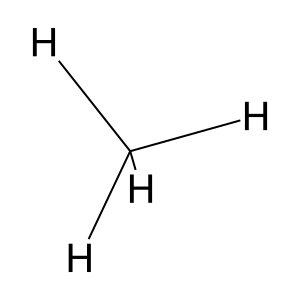

In [4]:
Draw.MolToImage(mol)

In [5]:
positions

tensor([[-1.6663e-09, -7.3706e-10, -1.9357e-09],
        [-6.7534e-02,  8.5412e-02, -8.5361e-03],
        [-3.9495e-02, -8.3594e-02, -5.8148e-02],
        [ 8.4754e-03, -2.9374e-02,  1.0485e-01],
        [ 9.8554e-02,  2.7556e-02, -3.8169e-02]])

To set up the input, we also need to define the `atomic_subsystem_indices` which indicate which system the atomic mumbers and positions correspond to, as this is designed to work with batched. E.g., a batch with two systems (and 2 atoms each), would have a tensor [0,0,1,1]. Note, while the `NeighborlistForTraining` is designed to take the pre-computed pairs as input (via the `NNPInput` class) for efficiency purposes, if they are not defined they will be computed in the training neighbor list  (as is done here).

In [6]:
data = NNPInput(atomic_numbers=atomic_numbers, positions=positions, atomic_subsystem_indices=torch.tensor([0,0,0,0,0], dtype=torch.int64), per_system_total_charge=None)


### Using the neighbor list
Here we will instantiate the neighbor list with a cutoff value;  since the neighbor list is not necessarily designed to be a user facing class, it uses internal units (which by default uses nanometers for distance).

When instantiating, we must define the cutoff distance as well as defined whether or not we will consider only unique pairs of particles; i.e., will we compute the `half` neighbor list (using only unique pairs) or the `full` neighbor list (not restricting to unique pairs).   By unique pairs we mean that the neighbor list would treat a pair of (0, 1) identical to (1, 0).  Most of the NNPs require the `full` neighbor list. 

Here we will instantiate for the `local` interactions by specifying the `local_cutoff` along with `local_only_unique_pairs` set to True.  As we can see from the positions tensor, a cutoff of 0.5 nm will include all the pairs.

In [7]:
cutoff = 0.5

nlist = NeighborListForTraining(local_cutoff=cutoff, local_only_unique_pairs=True)

output = nlist(data)

If we print the result we can see the structure of the structure of the output returned by the neighbor list. The output is a dataclass that contains 3 keys: `local_cutoff`, `vdw_cutoff`, `electrostatic_cutoff`.  Even if do not calculate the interacting pairs for the vdw or electrostatic cutoffs, we have place holder tensors in the output. 

In [8]:
output

PairlistOutputs(local_cutoff=PairlistData(pair_indices=tensor([[0, 0, 0, 0, 1, 1, 1, 2, 2, 3],
        [1, 2, 3, 4, 2, 3, 4, 3, 4, 4]]), d_ij=tensor([[0.1092],
        [0.1092],
        [0.1092],
        [0.1092],
        [0.1784],
        [0.1784],
        [0.1784],
        [0.1784],
        [0.1784],
        [0.1784]]), r_ij=tensor([[-0.0675,  0.0854, -0.0085],
        [-0.0395, -0.0836, -0.0581],
        [ 0.0085, -0.0294,  0.1049],
        [ 0.0986,  0.0276, -0.0382],
        [ 0.0280, -0.1690, -0.0496],
        [ 0.0760, -0.1148,  0.1134],
        [ 0.1661, -0.0579, -0.0296],
        [ 0.0480,  0.0542,  0.1630],
        [ 0.1380,  0.1111,  0.0200],
        [ 0.0901,  0.0569, -0.1430]]), only_unique_pairs=tensor(True)), vdw_cutoff=PairlistData(pair_indices=tensor([], size=(2, 0), dtype=torch.int64), d_ij=tensor([], size=(0, 1)), r_ij=tensor([], size=(0, 3)), only_unique_pairs=tensor(False)), electrostatic_cutoff=PairlistData(pair_indices=tensor([], size=(2, 0), dtype=torch.int64), 

Let us access the information associated with the `local_cutoff`, we we see that this is an instance of the `PairListData` dataclass, that contains `pair_indices`, `d_ij`, `r_ij`, and `only_unique_pairs`. 

In [9]:
output.local_cutoff

PairlistData(pair_indices=tensor([[0, 0, 0, 0, 1, 1, 1, 2, 2, 3],
        [1, 2, 3, 4, 2, 3, 4, 3, 4, 4]]), d_ij=tensor([[0.1092],
        [0.1092],
        [0.1092],
        [0.1092],
        [0.1784],
        [0.1784],
        [0.1784],
        [0.1784],
        [0.1784],
        [0.1784]]), r_ij=tensor([[-0.0675,  0.0854, -0.0085],
        [-0.0395, -0.0836, -0.0581],
        [ 0.0085, -0.0294,  0.1049],
        [ 0.0986,  0.0276, -0.0382],
        [ 0.0280, -0.1690, -0.0496],
        [ 0.0760, -0.1148,  0.1134],
        [ 0.1661, -0.0579, -0.0296],
        [ 0.0480,  0.0542,  0.1630],
        [ 0.1380,  0.1111,  0.0200],
        [ 0.0901,  0.0569, -0.1430]]), only_unique_pairs=tensor(True))

Let us reduce the cutoff such that we will only include the C-H pairs (e.g., setting this to be 0.15).

In [10]:
cutoff = 0.15

nlist = NeighborListForTraining(local_cutoff=cutoff, local_only_unique_pairs=True)

output = nlist(data)

Here we can see that we have exluded all the H-H pairs. 

In [11]:
output.local_cutoff

PairlistData(pair_indices=tensor([[0, 0, 0, 0],
        [1, 2, 3, 4]]), d_ij=tensor([[0.1092],
        [0.1092],
        [0.1092],
        [0.1092]]), r_ij=tensor([[-0.0675,  0.0854, -0.0085],
        [-0.0395, -0.0836, -0.0581],
        [ 0.0085, -0.0294,  0.1049],
        [ 0.0986,  0.0276, -0.0382]]), only_unique_pairs=tensor(True))

### only unique pairs

The example above sets `local_only_unique_pairs` to be `True`. If we toggle this to `False`, we will see that we now have twice the pairs, as we now consider, e.g., (0, 1) to be distinct from (1, 0)

In [12]:
cutoff = 0.15

nlist = NeighborListForTraining(local_cutoff=cutoff, local_only_unique_pairs=False)

output = nlist(data)

In [13]:
output.local_cutoff

PairlistData(pair_indices=tensor([[0, 0, 0, 0, 1, 2, 3, 4],
        [1, 2, 3, 4, 0, 0, 0, 0]]), d_ij=tensor([[0.1092],
        [0.1092],
        [0.1092],
        [0.1092],
        [0.1092],
        [0.1092],
        [0.1092],
        [0.1092]]), r_ij=tensor([[-0.0675,  0.0854, -0.0085],
        [-0.0395, -0.0836, -0.0581],
        [ 0.0085, -0.0294,  0.1049],
        [ 0.0986,  0.0276, -0.0382],
        [ 0.0675, -0.0854,  0.0085],
        [ 0.0395,  0.0836,  0.0581],
        [-0.0085,  0.0294, -0.1049],
        [-0.0986, -0.0276,  0.0382]]), only_unique_pairs=tensor(False))

### Operating on a batch

As noted, the `NeighborListForTraining` class is designed to work with batches of systems.  Let us simple add another methane to an instance of NNPInput and examine the result. 

Here, the output should only be C-H pairs in each of the molecules

In [14]:
batch_positions = torch.concatenate([positions, positions])
batch_atomic_numbers = torch.concatenate([atomic_numbers, atomic_numbers])
batch_atomic_sub_system_indices = torch.tensor([0,0,0,0,0,1,1,1,1,1], dtype=torch.int64)

data_batch = NNPInput(positions=batch_positions, atomic_numbers=batch_atomic_numbers, atomic_subsystem_indices=batch_atomic_sub_system_indices, per_system_total_charge=torch.tensor([0], dtype=torch.int64))

cutoff = 0.15

nlist = NeighborListForTraining(local_cutoff=cutoff, local_only_unique_pairs=True)

output = nlist(data_batch)

In [15]:
output.local_cutoff

PairlistData(pair_indices=tensor([[0, 0, 0, 0, 5, 5, 5, 5],
        [1, 2, 3, 4, 6, 7, 8, 9]]), d_ij=tensor([[0.1092],
        [0.1092],
        [0.1092],
        [0.1092],
        [0.1092],
        [0.1092],
        [0.1092],
        [0.1092]]), r_ij=tensor([[-0.0675,  0.0854, -0.0085],
        [-0.0395, -0.0836, -0.0581],
        [ 0.0085, -0.0294,  0.1049],
        [ 0.0986,  0.0276, -0.0382],
        [-0.0675,  0.0854, -0.0085],
        [-0.0395, -0.0836, -0.0581],
        [ 0.0085, -0.0294,  0.1049],
        [ 0.0986,  0.0276, -0.0382]]), only_unique_pairs=tensor(True))


## Nvidia ALCHEMI Toolkit-Ops Neighbor List

In [16]:
from nvalchemiops.neighborlist import neighbor_list

Warp DeprecationWarning: The symbol `warp.vec` will soon be removed from the public API. Use `warp.types.vector` instead.


### Full neighbor matrix

In [17]:
neighbor_matrix_full, num_neighbors_full = neighbor_list(
    positions=positions,
    cutoff=cutoff,
    max_neighbors=5,  # type: ignore
)

In [18]:
neighbor_matrix_full

tensor([[1, 2, 3, 4, 5],
        [0, 5, 5, 5, 5],
        [0, 5, 5, 5, 5],
        [0, 5, 5, 5, 5],
        [0, 5, 5, 5, 5]], dtype=torch.int32)

In [19]:
num_neighbors_full

tensor([4, 1, 1, 1, 1], dtype=torch.int32)

### Full neighbor list

In [20]:
neighbor_list_full, neighbor_ptr_full = neighbor_list(
    positions=positions,
    cutoff=cutoff,
    return_neighbor_list=True,
    max_neighbors=5,  # type: ignore
)

In [21]:
neighbor_list_full

tensor([[0, 0, 0, 0, 1, 2, 3, 4],
        [1, 2, 3, 4, 0, 0, 0, 0]], dtype=torch.int32)

In [22]:
neighbor_ptr_full

tensor([0, 4, 5, 6, 7, 8], dtype=torch.int32)

### Half neighbor matrix

In [23]:
neighbor_matrix_half, num_neighbors_half = neighbor_list(
    positions=positions,
    cutoff=cutoff,
    half_fill=True,
    max_neighbors=5,  # type: ignore
)

In [24]:
neighbor_matrix_half

tensor([[1, 2, 3, 4, 5],
        [5, 5, 5, 5, 5],
        [5, 5, 5, 5, 5],
        [5, 5, 5, 5, 5],
        [5, 5, 5, 5, 5]], dtype=torch.int32)

In [25]:
num_neighbors_half

tensor([4, 0, 0, 0, 0], dtype=torch.int32)

### Half neighbor list

In [26]:
neighbor_list_half, neighbor_ptr_half = neighbor_list(
    positions=positions,
    cutoff=cutoff,
    half_fill=True,
    return_neighbor_list=True,
    max_neighbors=5,  # type: ignore
)

In [27]:
neighbor_list_half

tensor([[0, 0, 0, 0],
        [1, 2, 3, 4]], dtype=torch.int32)

In [28]:
neighbor_ptr_half

tensor([0, 4, 4, 4, 4, 4], dtype=torch.int32)

### Working with batches

Let's focus on half-filled neighbor list for comparison with the modelforge neighbor list.

In [29]:
neighbor_list_half, neighbor_ptr_half = neighbor_list(
    batch_positions,
    cutoff,
    batch_idx=batch_atomic_sub_system_indices.to(torch.int32),
    half_fill=True,
    return_neighbor_list=True,
    max_neighbors=5,  # type: ignore
)

In [30]:
neighbor_list_half

tensor([[0, 0, 0, 0, 5, 5, 5, 5],
        [1, 2, 3, 4, 6, 7, 8, 9]], dtype=torch.int32)

In [31]:
neighbor_ptr_half

tensor([0, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8], dtype=torch.int32)

### Handle PBC

We can put a warning here saying that we don't support this for now.

## DFT-D3 Dispersion Correction with nvalchemi-toolkit-ops

Let's use the neighbor list provided by modelforge to do a D3 calculation.

In [32]:
from nvalchemiops.interactions.dispersion.dftd3 import dftd3
from nvalchemiops.interactions.dispersion.dftd3 import D3Parameters

Download and load the D3 parameters following the examples in the `nvalchemi-toolkit-ops` code base.

In [44]:
import os
from pathlib import Path

# function copied from nvalchemi-toolkit-ops/examples/dispersion/utils.py
# run utils.py as a script to get the d3_params downloaded to ~/.cache/nvalchemiops
def load_d3_parameters(
    param_file: Path | None = None,
) -> D3Parameters:
    """
    Load DFT-D3 parameters as a D3Parameters instance.

    Parameters
    ----------
    param_file : Path or None, optional
        Path to parameter file. If None, loads from default cache location
        (~/.cache/nvalchemiops/dftd3_parameters.pt).

    Returns
    -------
    D3Parameters
        Validated D3Parameters instance

    Raises
    ------
    FileNotFoundError
        If parameter file doesn't exist

    Examples
    --------
    Load from default cache:

    >>> params = load_d3_parameters()

    Load from specific file:

    >>> params = load_d3_parameters(Path("my_params.pt"))
    """
    if param_file is None:
        cache_dir = Path(os.path.expanduser("~")) / ".cache" / "nvalchemiops"
        param_file = cache_dir / "dftd3_parameters.pt"

    if not param_file.exists():
        raise FileNotFoundError(
            f"DFT-D3 parameter file not found: {param_file}\n"
            "Please run one of the example scripts to generate the parameter file.\n"
            "Example: python examples/interactions/01_dftd3_molecule.py"
        )

    state_dict = torch.load(param_file, map_location="cpu", weights_only=True)

    return D3Parameters(
        rcov=state_dict["rcov"],
        r4r2=state_dict["r4r2"],
        c6ab=state_dict["c6ab"],
        cn_ref=state_dict["cn_ref"],
    )

In [45]:
d3_params = load_d3_parameters()

d3_params

In [33]:
cutoff = 0.15

nlist = NeighborListForTraining(local_cutoff=cutoff, local_only_unique_pairs=True)

output = nlist(data)

In [61]:
output.local_cutoff.pair_indices

tensor([[0, 0, 0, 0],
        [1, 2, 3, 4]])

It is required to parse the `neighbor_ptr` when using `neighbor_list` format, which is not yet calculated or stored in the modelforge neighbor list. Let's use the `neighbor_ptr` calculated with the nvalchemi-toolkit-ops for now.

In [62]:
### Full neighbor list
neighbor_list_full, neighbor_ptr_full = neighbor_list(
    positions=positions,
    cutoff=cutoff,
    # half_fill=True,
    return_neighbor_list=True,
    max_neighbors=5,  # type: ignore
)

In [65]:
neighbor_list_full

tensor([[0, 0, 0, 0, 1, 2, 3, 4],
        [1, 2, 3, 4, 0, 0, 0, 0]], dtype=torch.int32)

In [66]:
neighbor_ptr_full

tensor([0, 4, 5, 6, 7, 8], dtype=torch.int32)

In [63]:
energy, forces, coord_num = dftd3(
    positions=positions,           # [num_atoms, 3] in Bohr
    numbers=atomic_numbers.to(torch.int32),               # [num_atoms] atomic numbers
    neighbor_list=neighbor_list_full,  # [2, num_pairs]
    # neighbor_list=output.local_cutoff.pair_indices.to(torch.int32),  # [2, num_pairs]
    neighbor_ptr=neighbor_ptr_full,
    a1=0.3981, a2=4.4211, s8=0.7875,
    d3_params=d3_params,
)

In [64]:
energy

tensor([-0.0008])

In [53]:
forces

tensor([[1.7957e-19, 0.0000e+00, 1.7279e-19],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])

In [54]:
coord_num

tensor([4., 0., 0., 0., 0.])